In [52]:
import pandas as pd
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [95]:
#hyper params
BATCH_SIZE = 100
LR = 0.001
HIDDEN1 = 64
HIDDEN2 = 32

In [96]:
def prepare_data():
    q_cleaned = pd.read_csv('data_vectorized_240228.csv')
    q_cleaned.drop(['ia_status_Facility Study', 'ia_status_Feasibility Study',
        'ia_status_IA Executed', 'ia_status_Operational',
        'ia_status_System Impact Study', 'Unnamed: 0'], axis=1, inplace=True)
    cols_to_drop = [col for col in q_cleaned.columns if col.startswith('util')]
    q_cleaned.drop(cols_to_drop,  axis=1, inplace=True)

    exempt = []
    for col in list(q_cleaned.columns):
        if q_cleaned[col].max() < 1:
              exempt.append(col)
    q_cleaned.drop(columns = exempt,axis=1, inplace=True)

    target = q_cleaned['ia_status_Withdrawn']
    features = q_cleaned.drop('ia_status_Withdrawn', axis=1)

    scaler = StandardScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

    seed = 42
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target,
                                                        test_size = 0.2,
                                                        random_state = seed)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data()

In [97]:
class Q_vecDataset(Dataset):
    def __init__(self, X, y, train):
        self.feature = X
        self.target = y
        self.train = train

    def __len__(self):
        return self.target.shape[0]

    def __getitem__(self, index):
        X = self.feature.iloc[index,:]
        X = X.to_numpy()
        y = self.target.iloc[index]

        return X, y

train_q_vec = Q_vecDataset(X=X_train, y=y_train, train=True)
test_q_vec = Q_vecDataset(X=X_test, y=y_test, train=False)

batch_size = BATCH_SIZE
train_dataloader = DataLoader(train_q_vec, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_q_vec, batch_size=batch_size, shuffle=False)
input_size = X_train.shape[1]
print(f"Input size: {input_size}")

Input size: 39


In [98]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

hidden1 = HIDDEN1
hidden2 = HIDDEN2

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return(x)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [99]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []
test_f1, t_labels, t_preds = [], [], []

num_epochs = 50
for epoch in range(num_epochs):
    #train
    model.train()
    run_loss = 0
    run_correct = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).to(torch.float32)
        labels = labels.to(device)

        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        run_loss += loss.item()*inputs.size(0)
        _, preds = torch.max(outputs.data, 1)
        run_correct += (preds == labels).type(torch.float32).sum().item()

    epoch_loss = run_loss / len(train_dataloader.dataset)
    epoch_acc = run_correct / len(train_dataloader.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    #test
    model.eval()
    test_run_loss = 0
    test_run_correct = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device).to(torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            t_loss = criterion(outputs, labels)
            test_run_loss += t_loss.item()*inputs.size(0)
            _, preds = torch.max(outputs.data, 1)
            test_run_correct += (preds == labels).type(torch.float32).sum().item()
            t_labels.extend(labels.tolist())
            t_preds.extend(preds.tolist())


    epoch_test_loss = test_run_loss / len(test_dataloader.dataset)
    epoch_test_acc = test_run_correct / len(test_dataloader.dataset)
    f1 = f1_score(t_labels, t_preds, average='binary')

    test_f1.append(f1)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    print(epoch)
    print(f"train loss: {epoch_loss}, test loss: {epoch_test_loss}")
    print(f"train acc: {epoch_acc}, test acc: {epoch_test_acc}")
    print(f"F1: {f1}")

0
train loss: 0.6789475475458333, test loss: 0.6563930809497833
train acc: 0.6336678832116789, test acc: 0.8512773722627737
F1: 0.46905537459283386
1
train loss: 0.6189655145480685, test loss: 0.5799034472799649
train acc: 0.8143248175182481, test acc: 0.875
F1: 0.4845360824742268
2
train loss: 0.5553600584721043, test loss: 0.5512201814320836
train acc: 0.8683850364963503, test acc: 0.8768248175182481
F1: 0.4971098265895954
3
train loss: 0.5298102429802836, test loss: 0.5452890612565688
train acc: 0.8264142335766423, test acc: 0.8366788321167883
F1: 0.4891846921797005
4
train loss: 0.5209253938039289, test loss: 0.5475654031020881
train acc: 0.8280109489051095, test acc: 0.8485401459854015
F1: 0.4875164257555848
5
train loss: 0.5211829265756328, test loss: 0.5469461922010366
train acc: 0.8353102189781022, test acc: 0.833029197080292
F1: 0.4830917874396135
6
train loss: 0.5124754873342323, test loss: 0.5463861170476371
train acc: 0.8346259124087592, test acc: 0.8156934306569343
F1: 0.4

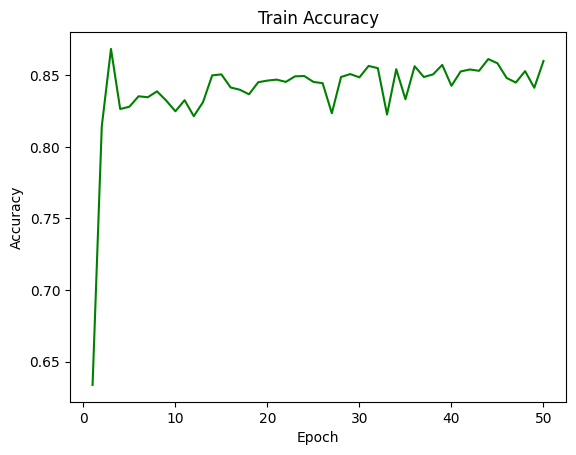

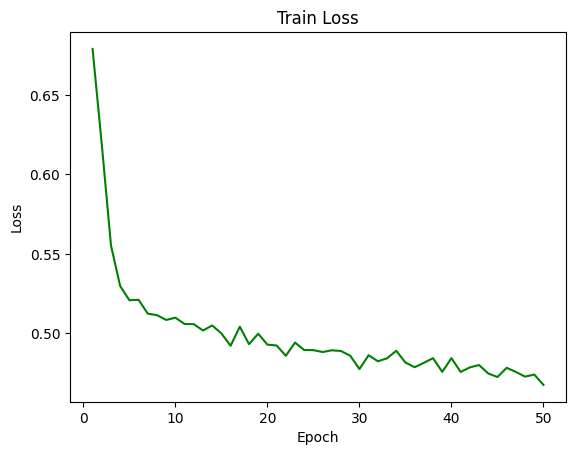

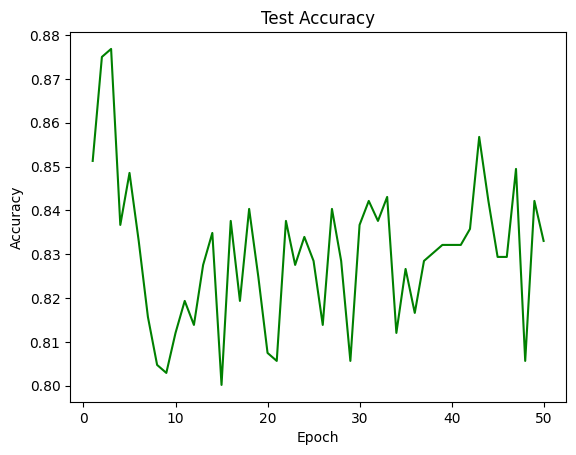

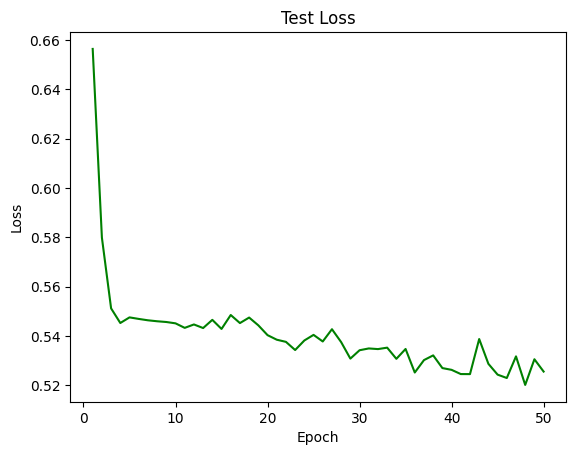

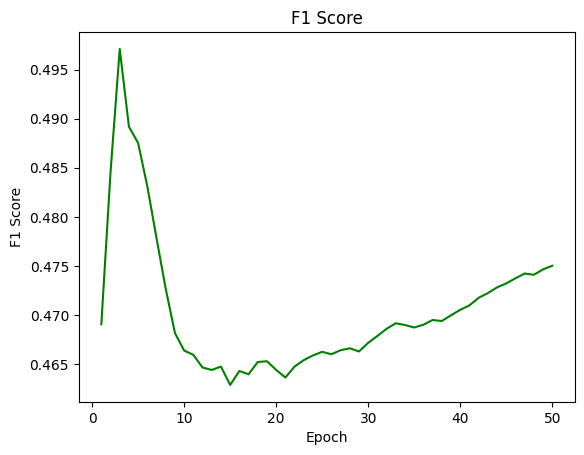

In [101]:
plt.plot(np.arange(1, 51), train_acc, color='green')
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.arange(1, 51), train_loss, color='green')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(1, 51), test_acc, color='green')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.arange(1, 51), test_loss, color='green')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(1, 51),  test_f1, color='green')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.show()

In [103]:
torch.save(model.state_dict(), 'model_full_state_dict.pth')

In [108]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('model_full_state_dict.pth'))

<All keys matched successfully>